<a href="https://colab.research.google.com/github/jakedorman64/Navier_Stokes/blob/main/Navier_Stokes_Solver_2D_With_Evaluator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Navier-Stokes Solver #

The Navier-Stokes Equations are:
$$ \frac{d\textbf{u}}{dt} + (\textbf{u} \cdot \nabla ) \textbf{u} = - \frac{1}{\rho} \nabla p + \nu \nabla^2 \textbf{u} + \textbf{f} $$
$$ \nabla \cdot \textbf{u} = 0 $$


Where:

*   $\rho$ is density,

*   $\textbf{u}$ is velocity,
*   $p$ is pressure,
*   $\nu$ is kinematic viscosity,
*   $\textbf{f}$ is the sum of all external forces.

We cannot use the standard Euler's method for numerically solving ODE's because this will not ensure that the second equation is fulfilled, i.e. that the divergence of the velocity is 0. Using the standard Euler Method also does not give an equation to update the pressure.

Instead, we update the the velocities and pressure using the following scheme:

1.   Find an intermidiate velocity $ \textbf{u}^* $ from the first Navier-Stokes Equation using: $$ \textbf{u}^* = \textbf{u}^n  - dt (\textbf{u}^n \cdot \nabla  ) \textbf{u}^n + dt \, \nu \nabla^2 \textbf{u}^n + dt \,\textbf{f}^{\,n} $$
2.   Solve the following equation for pressure: $$ \nabla^2 p^{n+1}  = \frac{\rho}{dt} \nabla \cdot \textbf{u}^*. $$ For this, we can use standard numerical methods, i.e. Euler's method.
3.   Update velocity using: $$ \textbf{u}^{n+1} = \textbf{u}^* - \frac{dt}{\rho} \nabla p^{n+1} $$

Where $ \textbf{f}^{\, n} $ is the external force at time $t_n,$ which evolves independently of the state of our simulation.

The derivation of this approach is in section 2.1 [here](http://hplgit.github.io/INF5620/doc/pub/main_ns.pdf).

Step 1 and 3 can be solved directly, by substituting the values from the previous step into the current step. Step 2 requires the use of a Jacobi Iterative Procedure as described [here](https://people.eecs.berkeley.edu/~demmel/cs267/lecture24/lecture24.html).

The boundary conditions for the velocity are Dirichlet Boundaries, meaning that the velocities at the perimeter of the box are known and unchanging. If this is 0, it represents the 'no slip' condition of viscous fluids.

Since we assume the box does not expand under pressure, the pressure on the inside edge of the boundary must be equal to the pressure on the outside at all times. Thus, the gradient of the pressure at the boundary must be 0. This is a Neumann Boundary Condition.

In [1]:
import jax.random as random
import jax.numpy as jnp
from jax.config import config
import numpy as np
from jax import jit
import matplotlib.pyplot as plt
import time

config.update("jax_debug_nans", True) # If TIMESTEP is too small, the code will create NaNs. This line ensures that JAX stops the code if a NaN is found, rather than continuing.

In [2]:
"""
CONSTANTS.

  [+] N_POINTS: The number of points we will split our axis into in each direction. I.e, for N_POINTS = 4, our grid will be:

                  0 _ _ 1
               0  + + + +
               |  + + + +
               |  + + + +
               1  + + + +

  [+] dt: the size of our time intervals.
  [+] TIMESTEPS: How many timesteps to solve for. Hence, the total length of time in the future that we solve for is dt * TIMESTEPS
  [+] VISCOSITY: The viscosity of our fluid.
  [+] DENSITY: The density of ther fluid.
  [+] JACOBI_ITERATIONS: How many Jacobi Iterations to use to solve for the pressure.
  [+] IMAGE_SCALAR: Ensures all images are scaled the same way, so that if N_POINTS is higher the density of points on the map doesn't get so high it's impossible to make anything out.
  [+] ELEMENT_LENGTH: The distance between consecutive points in the grid.

"""

N_POINTS = 128
dt = 0.00001
TIMESTEPS = 5000
VISCOSITY = 0.1
DENSITY = 1.0
JACOBI_ITERATIONS = 500

IMAGE_SCALAR = int(N_POINTS / 32)

ELEMENT_LENGTH = 1 / (N_POINTS - 1)

## Define Initial Conditions

In [3]:
# All of this code is provided by Niall Jeffrey, to create a 2D Divergence Free Vector Field to use as the initial conditions for the simulation.

# This is the function that generates our divergence free vector field for the velocity.

def k2g_fft(kE, kB, dx, pad=True):
    """
    Convert kappa to gamma in Fourier space. If padding is
    set to True, include the same size of padding as the data
    on each side, the total grid is 9 times the original.
    """

    if pad:
        kE_temp = np.zeros((len(kE)*3, len(kE[0])*3))
        kB_temp = np.zeros((len(kB)*3, len(kE[0])*3))
        kE_temp[len(kE):len(kE)*2, len(kE[0]):len(kE[0])*2] = kE*1.0
        kB_temp[len(kB):len(kB)*2, len(kB[0]):len(kB[0])*2] = kB*1.0
        kE_3d_ft = np.fft.fft2(kE_temp)
        kB_3d_ft = np.fft.fft2(kB_temp)
    else:
        kE_3d_ft = np.fft.fft2(kE)
        kB_3d_ft = np.fft.fft2(kB)

    FF1 = np.fft.fftfreq(len(kE_3d_ft))
    FF2 = np.fft.fftfreq(len(kE_3d_ft[0]))

    dk = 1.0/dx*2*np.pi                     # max delta_k in 1/arcmin
    kx = np.dstack(np.meshgrid(FF2, FF1))[:,:,0]*dk
    ky = np.dstack(np.meshgrid(FF2, FF1))[:,:,1]*dk
    kx2 = kx**2
    ky2 = ky**2
    k2 = kx2 + ky2

    k2[k2==0] = 1e-15
    k2gamma1_ft = kE_3d_ft/k2*(kx2-ky2) - kB_3d_ft/k2*2*(kx*ky)
    k2gamma2_ft = kE_3d_ft/k2*2*(kx*ky) + kB_3d_ft/k2*(kx2-ky2)

    if pad:
        return np.fft.ifft2(k2gamma1_ft).real[len(kE):len(kE)*2, len(kE[0]):len(kE[0])*2], np.fft.ifft2(k2gamma2_ft).real[len(kE):len(kE)*2, len(kE[0]):len(kE[0])*2]
    else:
        return np.fft.ifft2(k2gamma1_ft).real, np.fft.ifft2(k2gamma2_ft).real

def compute_spectrum_map(power1d,size):
    """
    takes 1D power spectrum and makes it an isotropic 2D map
    :param power: 1d power spectrum
    :param size:
    :return:
    """

    power_map = np.zeros((size, size), dtype = float)
    k_map =  np.zeros((size, size), dtype = float)

    for (i,j), val in np.ndenumerate(power_map):

        k1 = i - size/2.0
        k2 = j - size/2.0
        k_map[i, j] = (np.sqrt(k1*k1 + k2*k2))

        if k_map[i,j] == 0:
            power_map[i, j] = 1e-15
        else:
            power_map[i, j] = power1d[int(k_map[i, j])]

    return power_map



def gaussian_mock(spectrum_map_flat_sqrt,image_size):
    gaussian_field = np.random.normal(0, spectrum_map_flat_sqrt) + 1j*np.random.normal(0, spectrum_map_flat_sqrt)
    gaussian_field = np.fft.ifft2(np.fft.fftshift(gaussian_field.reshape((image_size,image_size)))).imag
    return gaussian_field

karray = np.arange(N_POINTS)
pk = np.exp(-karray * karray / 5)

spectrum_map = compute_spectrum_map(pk, N_POINTS)

field = gaussian_mock(spectrum_map.flatten(), N_POINTS).T

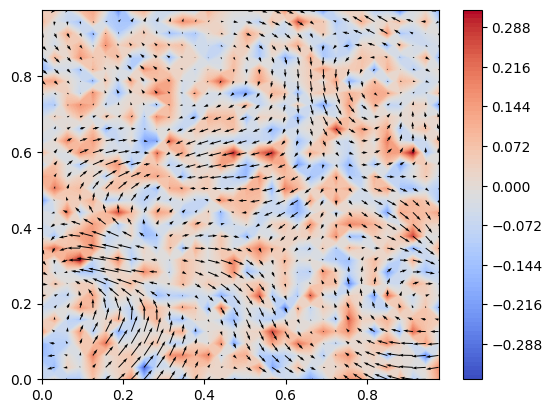

In [4]:
# The domain of the grid will be [0, 1] x [0, 1], split into N_POINTS x N_POINTS individual points.
x = jnp.linspace(0.0, 1, N_POINTS)
y = jnp.linspace(0.0, 1, N_POINTS)

X, Y = jnp.meshgrid(x, y)

# To make the initial velocities, call upon the function to generate a divergence free field, to satisfy the second Navier-Stokes Equation.
u_init, v_init = k2g_fft(field*0, field, dx=1, pad=False)

# The pressures at each point can be generated from a normal distribution. A pressure value must be generated for each point in the domain.
key = random.PRNGKey(int(time.time()))
p_init = 0.1 * random.normal(key=key, shape=X.shape)

#This produces the plot of the initial conditions. The ::IMAGE_SCALAR notation selects only the points that are a multiple of IMAGE_SCALAR.
plt.figure()
plt.contourf(X[::IMAGE_SCALAR, ::IMAGE_SCALAR], Y[::IMAGE_SCALAR, ::IMAGE_SCALAR], p_init[::IMAGE_SCALAR, ::IMAGE_SCALAR], 100, cmap="coolwarm")
plt.colorbar()
plt.quiver(X[::IMAGE_SCALAR, ::IMAGE_SCALAR], Y[::IMAGE_SCALAR, ::IMAGE_SCALAR], u_init[::IMAGE_SCALAR, ::IMAGE_SCALAR], v_init[::IMAGE_SCALAR, ::IMAGE_SCALAR], color="black")
plt.show()

## Define the Derivative Functions


The derivatives are defined using a finite difference method, meaning if the grid is:

          (i-1, j-1), (i, j-1), (i+1, j-1)
           (i-1, j),   (i, j),   (i+1, j)
          (i-1, j+1), (i, j+1), (i+1, j+1)

and $\epsilon$ is the ELEMENT_LENGTH, the first derivatives are defined as:

$$ \begin{align} \frac{d}{dx}f(i, j) & = \frac{f(i+1, j) - f(i-1,j)}{2 \epsilon} \\ \frac{d}{dy}f(i, j) & = \frac{f(i, j+1) - f(i,j-1)}{2 \epsilon} \end{align} $$

The second derivatives are defined as:

$$ \begin{align} \frac{d^2}{dx^2}f(i, j) & = \frac{f(i+1, j) + f(i-1,j) - 2 f(i, j)}{\epsilon^2}  \\ \frac{d^2}{dy^2}f(i, j) & = \frac{f(i, j+1) + f(i,j-1) - 2 f(i, j)}{\epsilon^2} \end{align} $$

The Laplacian function can be defined using the sum of the second central differences, but explicitly this gives:

$$ \nabla^2 f(i, j) = \frac{f(i,j-1) + f(i, j+1) + f(i+1, j) + f(i-1, j) - 4 f(i, j)}{\epsilon^2}. $$

Due to the Dirichlet Boundary Conditions, the derivatives on the perimeter will always be 0 as these points are unchanging. Hence, only the derivatives of the interior points must be calculated.

In [5]:
@jit
def d_dx(f):
  diff = jnp.zeros_like(f)
  diff = diff.at[1:-1, 1:-1].set((f[1:-1, 2:  ] - f[1:-1, 0:-2] ) / ( 2 * ELEMENT_LENGTH))
  return diff

@jit
def d_dy(f):
  diff = jnp.zeros_like(f)
  diff = diff.at[1:-1, 1:-1].set((f[2:, 1:-1  ] - f[0:-2, 1:-1] ) / ( 2 * ELEMENT_LENGTH))
  return diff

@jit
def d2_dx2(f):
  diff = jnp.zeros_like(f)
  diff = diff.at[1:-1, 1:-1].set((f[1:-1, 2:  ] - 2 * f[1:-1, 1:-1] + f[1:-1, 0:-2] ) / (ELEMENT_LENGTH**2))
  return diff

@jit
def d2_dy2(f):
  diff = jnp.zeros_like(f)
  diff = diff.at[1:-1, 1:-1].set((f[2:, 1:-1  ] - 2 * f[1:-1, 1:-1] + f[0:-2, 1:-1] ) / (ELEMENT_LENGTH**2))
  return diff

@jit
def laplacian(f):
  return d2_dx2(f) + d2_dy2(f)

## Step 1: Intermediate Velocity

The intermediate velocity is: $$ \textbf{u}^* = \textbf{u}^n  - dt (\textbf{u}^n \cdot \nabla  ) \textbf{u}^n + dt \, \nu \nabla^2 \textbf{u}^n $$
Writing this out in terms of our individual components $u$ and $v$ gives:
$$ \begin{align} u^* & = u - dt \left( u \frac{\partial u}{\partial x} + v \frac{ \partial u}{\partial y} \right) + dt \, \nu \nabla^2 u \\ v^* & = v - dt \left( u \frac{\partial v}{\partial x} + v \frac{ \partial v}{\partial y} \right) + dt \, \nu \nabla^2 v \end{align} $$

In [6]:
@jit
def u_intermediate(u, v):
  return u - dt * (jnp.multiply(u, d_dx(u)) + jnp.multiply(v, d_dy(u))) + dt * VISCOSITY * laplacian(u)

@jit
def v_intermediate(u, v):
  return v - dt * (jnp.multiply(u, d_dx(v)) + jnp.multiply(v, d_dy(v))) + dt * VISCOSITY * laplacian(v)

## Step 2: Pressure

The equation for updating pressure is:
$$ \nabla^2 p^{n+1}  = \frac{\rho}{dt} \nabla \cdot \textbf{u}^*. $$
Also recall that our 5 point estimate
 for the Laplacian is:
$$ \nabla^2 p(0, 0) = \frac{p(0,-1) + p(0, 1) + p(1, 0) + p(-1, 0) - 4 p(0, 0)}{\epsilon^2} $$
Substituting this into the equation for pressure and rearranging gives:
$$ p(0,0) = \frac{1}{4} \left(p(0,-1) + p(0, 1) + p(1, 0) + p(-1, 0) - \epsilon^2 \frac{\rho}{dt} \nabla \cdot \textbf{u}^*(0, 0) \right) $$

Which is an estimate for pressure at each point. This formula can be used reccursively to find the pressure more accurately at each time step. This is the Jacobi method for estimating the pressure.

In [7]:
@jit
def p_update(u, v, p_prev):
  # Define the right hand side of the pressure equation.
  rhs = DENSITY / dt * (d_dx(u) + d_dy(v))

  for i in range(JACOBI_ITERATIONS):
    p_next = jnp.zeros_like(p_prev)

    # Add all of the previous pressure terms.
    p_next = p_next.at[1:-1, 1:-1].set(0.25 * (p_prev[1:-1,2: ] + p_prev[1:-1, 0:-2] + p_prev[2:, 1:-1] + p_prev[0:-2, 1:-1] - ELEMENT_LENGTH**2 * rhs[1:-1,1:-1])) #Interior vertical points.

    # Fix the boundary conditions. These are Neumann, i.e the gradient is fixed, so the pressures at this point will just be equal to the pressure next to it.
    p_next = p_next.at[:, -1].set(p_next[:, -2])
    p_next = p_next.at[0,  :].set(p_next[1,  :])
    p_next = p_next.at[:,  0].set(p_next[:,  1])
    p_next = p_next.at[-1, :].set(p_next[-1, :])

  return p_next

## Step 3: Final Velocity

The final velocity is updated using:
$$ \textbf{u}^{n+1} = \textbf{u}^* - \frac{dt}{\rho} \nabla p^{n+1} $$
In component form, this is:
$$ \begin{align} u^{n+1} & = u^* - \frac{dt}{\rho} \frac{d u}{dx} \\ v^{n+1} & =  v^* - \frac{dt}{\rho} \frac{dv}{dy} \end{align} $$

In [8]:
@jit
def u_update(u, p):
  return (u - (dt / DENSITY) * d_dx(p))

@jit
def v_update(v, p):
  return (v - (dt / DENSITY) * d_dy(p))

## Iterator



In [9]:
u_prev, v_prev, p_prev = u_init, v_init, p_init

@jit
def iterator(u_prev, v_prev, p_prev):
  # Calculate the intermediate velocities.
  u_i = u_intermediate(u_prev, v_prev)
  v_i = v_intermediate(u_prev, v_prev)

  # Set outside boundaries to the initial conditions.
  u_i = u_i.at[0, :].set(u_init[0, :])
  u_i = u_i.at[:, 0].set(u_init[:, 0])
  u_i = u_i.at[:, -1].set(u_init[:, -1])
  u_i = u_i.at[-1, :].set(u_init[:, -1])
  v_i = v_i.at[0, :].set(v_init[0, :])
  v_i = v_i.at[:, 0].set(v_init[:, 0])
  v_i = v_i.at[:, -1].set(v_init[:, -1])
  v_i = v_i.at[-1, :].set(v_init[-1, :])

  # Update the pressure.
  p_next = p_update(u_i, v_i, p_prev)

  #Update the final velocities.
  u_next = u_update(u_i, p_prev)
  v_next = v_update(v_i, p_prev)

  # set the outside boundaries to the boundary conditions again.

  u_next = u_next.at[0, :].set(u_init[0, :])
  u_next = u_next.at[:, 0].set(u_init[:, 0])
  u_next = u_next.at[:, -1].set(u_init[:, -1])
  u_next = u_next.at[-1, :].set(u_init[-1, :])
  v_next = v_next.at[0, :].set(v_init[0, :])
  v_next = v_next.at[:, 0].set(v_init[:, 0])
  v_next = v_next.at[:, -1].set(v_init[:, -1])
  v_next = v_next.at[-1, :].set(v_init[-1, :])

  return u_next, v_next, p_next

Timestep 0, time = 0.0


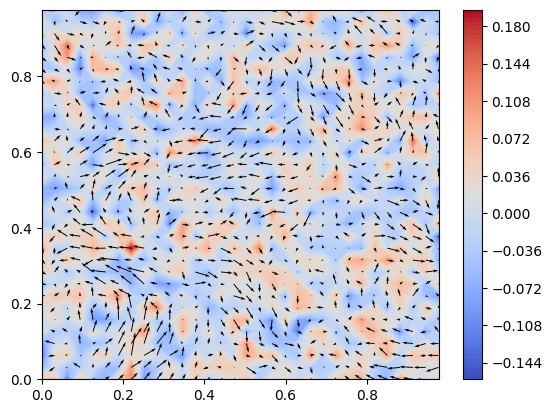

Timestep 1000, time = 0.01


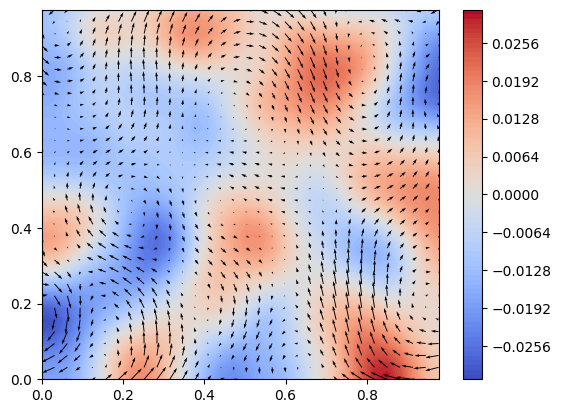

Timestep 2000, time = 0.02


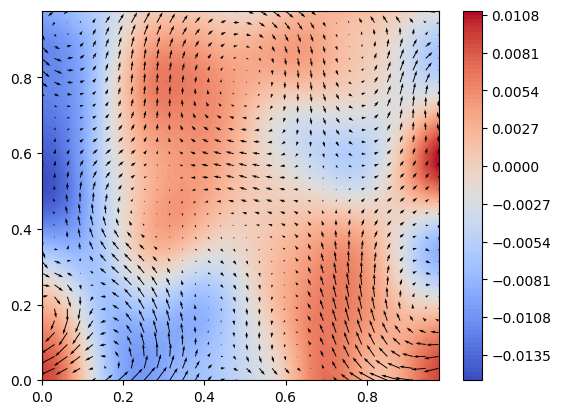

Timestep 3000, time = 0.030000000000000002


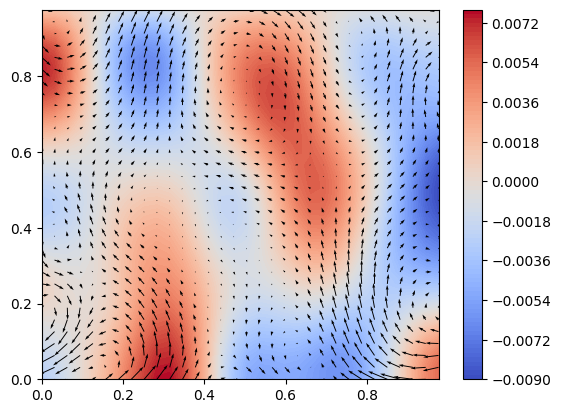

Timestep 4000, time = 0.04


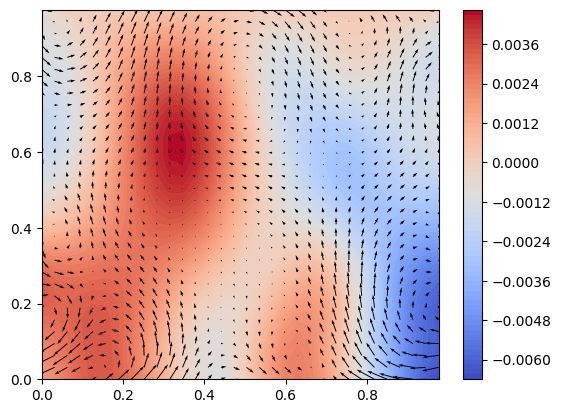

In [10]:
# This is the iterative loop.
for i in range(TIMESTEPS):
  # Update the values of u, v and p.
  u_prev, v_prev, p_prev = iterator(u_prev, v_prev, p_prev)

  #Print an image of the system every 1000 points.
  if i % 1000 == 0:
    print(f"Timestep {i}, time = {i*dt}")

    plt.figure()
    plt.contourf(X[::IMAGE_SCALAR, ::IMAGE_SCALAR], Y[::IMAGE_SCALAR, ::IMAGE_SCALAR], p_prev[::IMAGE_SCALAR, ::IMAGE_SCALAR], 100, cmap="coolwarm")
    plt.colorbar()

    plt.quiver(X[::IMAGE_SCALAR, ::IMAGE_SCALAR], Y[::IMAGE_SCALAR, ::IMAGE_SCALAR], u_prev[::IMAGE_SCALAR, ::IMAGE_SCALAR], v_prev[::IMAGE_SCALAR, ::IMAGE_SCALAR])

    plt.show()
    plt.close()

## Testing


The code below is for evaluating the model. It compares 3 different iterators:

1.   With the constants as stated above,
2.   With N_POINTS halved,
3.   With TIMESTEPS multiplied by 10 and dt divided by 10.

The second cell will output an image of each system after the same amount of time in the future (dt*TIMESTEPS), and then print out the mean squared error between the 2nd and 3rd systems with the first one. If the iterator is working, the mean squared errors should be very low and the images should look the same.

In [11]:
# Redefine the starting points for each of the 3 methods.
u_prev_standard = u_init
v_prev_standard = u_init
p_prev_standard = p_init

# The notation below selects every even point. New initial values must be created for the points_halved values, since these arrays will be a different size
# to the original initial arrays.
u_init_points_halved = u_init[::2, ::2]
v_init_points_halved = v_init[::2, ::2]
p_init_points_halved = p_init[::2, ::2]

u_prev_points_halved = u_init[::2, ::2]
v_prev_points_halved = v_init[::2, ::2]
p_prev_points_halved = p_prev[::2, ::2]

# redefine
u_prev_dt_divided = u_init
v_prev_dt_divided = v_init
p_prev_dt_divided = p_init

# The iterator function above automatically fixes the fixed points to the init values determined at the start. To run our iterator with the points halved, this will not work as
# the initial values have a different shape to u_prev_point_halved etc. Hence, this is a new iterator function:

@jit
def iterator_points_halved(u_prev, v_prev, p_prev):
  u_i = u_intermediate(u_prev, v_prev)
  v_i = v_intermediate(u_prev, v_prev)

  # Set outside boundaries to the initial conditions.
  u_i = u_i.at[0, :].set(u_init_points_halved[0, :])
  u_i = u_i.at[:, 0].set(u_init_points_halved[:, 0])
  u_i = u_i.at[:, -1].set(u_init_points_halved[:, -1])
  u_i = u_i.at[-1, :].set(u_init_points_halved[:, -1])
  v_i = v_i.at[0, :].set(v_init_points_halved[0, :])
  v_i = v_i.at[:, 0].set(v_init_points_halved[:, 0])
  v_i = v_i.at[:, -1].set(v_init_points_halved[:, -1])
  v_i = v_i.at[-1, :].set(v_init_points_halved[-1, :])

  # Update the Pressure
  p_next = p_update(u_i, v_i, p_prev)

  #Update the Final Velocities
  u_next = u_update(u_i, p_prev)
  v_next = v_update(v_i, p_prev)

  # set outside boundaries to the initial conditions again.

  u_next = u_next.at[0, :].set(u_init_points_halved[0, :])
  u_next = u_next.at[:, 0].set(u_init_points_halved[:, 0])
  u_next = u_next.at[:, -1].set(u_init_points_halved[:, -1])
  u_next = u_next.at[-1, :].set(u_init_points_halved[-1, :])
  v_next = v_next.at[0, :].set(v_init_points_halved[0, :])
  v_next = v_next.at[:, 0].set(v_init_points_halved[:, 0])
  v_next = v_next.at[:, -1].set(v_init_points_halved[:, -1])
  v_next = v_next.at[-1, :].set(v_init_points_halved[-1, :])

  return u_next, v_next, p_next

for i in range(TIMESTEPS):
  u_prev_standard, v_prev_standard, p_prev_standard = iterator(u_prev_standard, v_prev_standard, p_prev_standard)
  u_prev_points_halved, v_prev_points_halved, p_prev_points_halved = iterator_points_halved(u_prev_points_halved, v_prev_points_halved, p_prev_points_halved)

dt = dt / 10
for i in range(TIMESTEPS * 10):
  u_prev_dt_divided, v_prev_dt_divided, p_prev_dt_divided = iterator(u_prev_dt_divided, v_prev_dt_divided, p_prev_dt_divided)

dt = dt * 10

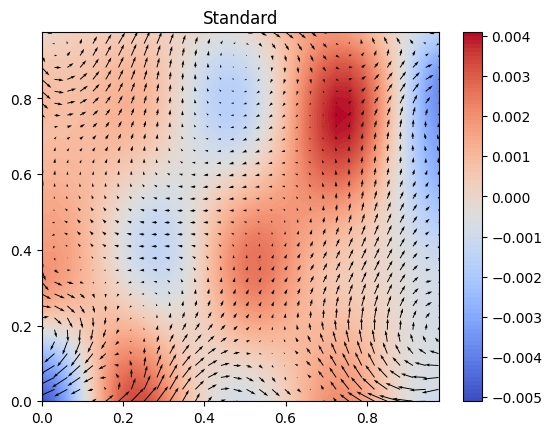

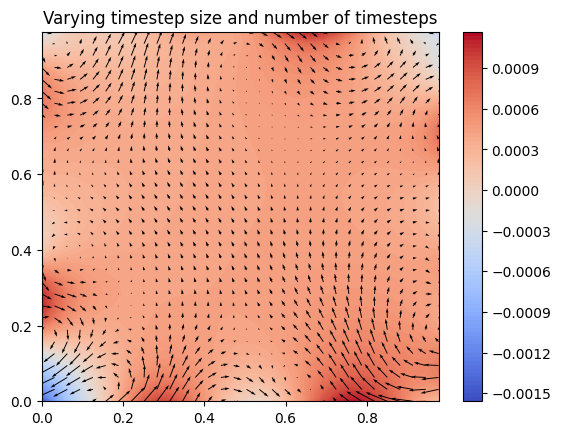

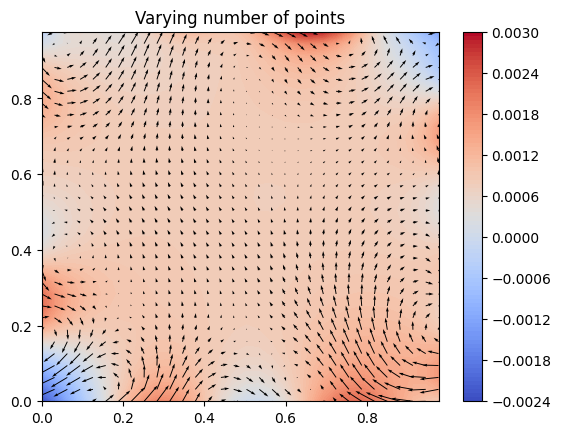

Mean Squared Error of u from varying timestep size:  8.6135665e-10
Mean Squared Error of v from varying timestep size:  9.414399e-10
Mean Squared Error of p from varying timestep size:  1.724082e-06
Mean Squared Error of u from halving number of points:  9.745005e-10
Mean Squared Error of v from halving number of points:  8.6720503e-10
Mean Squared Error of p from halving number of points:  1.8138426e-06


In [12]:
plt.figure()
plt.contourf(X[::IMAGE_SCALAR, ::IMAGE_SCALAR], Y[::IMAGE_SCALAR, ::IMAGE_SCALAR], p_prev_standard[::IMAGE_SCALAR, ::IMAGE_SCALAR], 100, cmap="coolwarm")
plt.colorbar()
plt.title("Standard")

plt.quiver(X[::IMAGE_SCALAR, ::IMAGE_SCALAR], Y[::IMAGE_SCALAR, ::IMAGE_SCALAR], u_prev_standard[::IMAGE_SCALAR, ::IMAGE_SCALAR], v_prev_standard[::IMAGE_SCALAR, ::IMAGE_SCALAR])

plt.show()
plt.close()

plt.figure()
plt.contourf(X[::IMAGE_SCALAR, ::IMAGE_SCALAR], Y[::IMAGE_SCALAR, ::IMAGE_SCALAR], p_prev_dt_divided[::IMAGE_SCALAR, ::IMAGE_SCALAR], 100, cmap="coolwarm")
plt.colorbar()
plt.title("Varying timestep size and number of timesteps")

plt.quiver(X[::IMAGE_SCALAR, ::IMAGE_SCALAR], Y[::IMAGE_SCALAR, ::IMAGE_SCALAR], u_prev_dt_divided[::IMAGE_SCALAR, ::IMAGE_SCALAR], v_prev_dt_divided[::IMAGE_SCALAR, ::IMAGE_SCALAR])

plt.show()
plt.close()

plt.figure()
plt.contourf(X[::IMAGE_SCALAR, ::IMAGE_SCALAR], Y[::IMAGE_SCALAR, ::IMAGE_SCALAR], p_prev_points_halved[::int(IMAGE_SCALAR/2), ::int(IMAGE_SCALAR/2)], 100, cmap="coolwarm")
plt.colorbar()
plt.title("Varying number of points")

plt.quiver(X[::IMAGE_SCALAR, ::IMAGE_SCALAR], Y[::IMAGE_SCALAR, ::IMAGE_SCALAR], u_prev_points_halved[::int(IMAGE_SCALAR/2), ::int(IMAGE_SCALAR/2)], v_prev_points_halved[::int(IMAGE_SCALAR/2), ::int(IMAGE_SCALAR/2)])

plt.show()
plt.close()

def mse(A, B):
  return ((A - B)**2).mean()

print("Mean Squared Error of u from varying timestep size: ", mse(u_prev_standard, u_prev_dt_divided))
print("Mean Squared Error of v from varying timestep size: ", mse(v_prev_standard, v_prev_dt_divided))
print("Mean Squared Error of p from varying timestep size: ", mse(p_prev_standard, p_prev_dt_divided))

print("Mean Squared Error of u from halving number of points: ", mse(u_prev_standard[::2, ::2], u_prev_points_halved))
print("Mean Squared Error of v from halving number of points: ", mse(v_prev_standard[::2, ::2], v_prev_points_halved))
print("Mean Squared Error of p from halving number of points: ", mse(p_prev_standard[::2, ::2], p_prev_points_halved))
